# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.data_analysis import FeatureAnalysis, NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.data_pipeline_segments import FeatureTransformer, TypeFixer, DataEncoder
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.sys_utils import create_dir_structure
from eflow.utils.eflow_utils import create_color_dict_for_features
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features 

import pandas as pd
import numpy as np
import scikitplot as skplt
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking
import nltk

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [4]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    """
    Desc:
        Creates a new jupyter cell.
    """
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    """
    Desc:
        Converts a list to a string and adds newlines for formating.
    """
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            output_str += f'\"{element}\"'
        else:
            output_str += f'\"{element}\",'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str

def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove.
    
    Args:
        df:
            Pandas DataFrame object
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove based on nulls.
    
    Args:
        df:
            Pandas DataFrame object
            
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)

    cell_content = __format_list_to_string("remove_null_features",
                                            mis_val_percent[mis_val_percent > null_threshold].index.to_list())
    # Add a calling card of the function that created it
    cell_content += f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n"
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_feature_value_color_dict(df,
                                                  df_features,
                                                  value_limit=50,
                                                  replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object
        
        df_features:
            DataFrameTypes object.
        
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_color_dict = create_color_dict_for_features(df,
                                                              df_features,
                                                              value_limit)
    # Add a sort of calling card of the function that created it
    cell_content = ""
    cell_content += f"# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "feature_value_color_dict=dict()"
    feature_count = 0
    for feature_name, feature_value_color in feature_value_color_dict.items():
        if feature_value_color_dict[feature_name].keys(): 
            cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"] = dict()"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give colors to each!"
        
        for feature_value, color in feature_value_color.items():

            color = feature_value_color_dict[feature_name][feature_value]
            
            if isinstance(feature_value,str):
                feature_value = f"\"{feature_value}\""
            else:
                feature_value = f"{feature_value}"
            
            if color is None:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = None"
            else:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = \"{color}\""
        cell_content += "\n"
        
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_categorical_dict(df,
                                          df_features,
                                          value_limit=50,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a dict of
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """

    cell_content = ""
    cell_content += f"# create_new_cell_with_categorical_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "categorical_value_dict = dict()"
    for feature_name in df_features.get_categorical_features():
        
        # Find and sort feature values
        feature_values = df[feature_name].value_counts(sort=False).index.to_list()
        feature_values = [str(val) for val in feature_values]
        feature_values.sort()
        
        # Create feature cat dict
        cat_found = False
        categorical_value_dict[feature_name] = dict()
        for val in feature_values:
            try:
                categorical_value_dict[feature_name][int(val)] = ""
                cat_found = True
            except ValueError:
                pass
        
        # Delete feature name if no categories are found
        if not cat_found:
            del categorical_value_dict[feature_name]
    
    for feature_name,cat_val_dict in categorical_value_dict.items():
        
        if len(cat_val_dict.keys()) < value_limit:
            cell_content += f"categorical_value_dict[\"{feature_name}\"]=dict()\n"
            for cat,val in cat_val_dict.items():

                if isinstance(val,str):
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = \"{val}\"\n"
                else:
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = {val}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give encode to each!"

        

    create_new_cell(cell_content,
                    replace=replace)
    
    

def create_new_cell_with_value_representation(df,
                                              df_features,
                                              value_limit=50,
                                              replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_representation = dict()
    for feature_name in df_features.get_string_features():
        feature_value_representation[feature_name] = dict()
        for val in df[feature_name].dropna().value_counts(sort=False).index.to_list():
            if isinstance(val,str):
                if len(val) == 0:
                    continue
                if len(val) <= 3 or val not in words.words():
                    feature_value_representation[feature_name][val] = ""

                if len(feature_value_representation[feature_name].keys()) >= 50:
                    break

        if not len(feature_value_representation[feature_name].keys()):
            del feature_value_representation[feature_name]
    cell_content = ""
    cell_content += f"# create_new_cell_with_value_representation(df,df_features,value_limit={value_limit},replace={replace})\n"
    
    cell_content += "feature_value_representation = dict()\n"
    for feature_name,val_repr_dict in feature_value_representation.items():
        
        if len(val_repr_dict.keys()) < value_limit:
            cell_content += f"feature_value_representation[\"{feature_name}\"] = dict()\n"
            for val,reprs in val_repr_dict.items():

                if isinstance(val,str):
                    cell_content += f"feature_value_representation[\"{feature_name}\"][\"{val}\"] = "
                else:
                    cell_content += f"feature_value_representation[\"{feature_name}\"][{val}] = "
                
                if isinstance(reprs,str):
                    cell_content += f"\"{reprs}\"\n"
                else:
                    cell_content += f"{reprs}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give representation to to each!"
        
        cell_content += "\n"
    create_new_cell(cell_content,
                    replace=replace)

## Declare Project Variables

### Interaction required

In [5]:
dataset_path = "Datasets/titanic_train.csv"
dataset_name = "Titanic Data"

# -----
peek_project_dir = f"{dataset_name}/Before Cleaning"

# -----
notebook_mode = True

# Import dataset

In [6]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Throwing in garbage data for testing purposes only!!!

In [7]:
# df["Sex"][0] = np.nan
# df["Sex"][2] = "Blarg"
# df["Age"] = df["Age"].astype('object')
# df["Age"][33] = "      "
# df["Pclass"][50] = "2sdf,asdqw"
# df["Pclass"][50] = "4th Class"
# df["SibSp"][2] = np.nan
# df["Embarked"][2] = 1

In [8]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


## Remove/Declare any unwanted features

### Interaction required

Note: When starting a new project uncomment the function to get suggestions and then run the cell again.

In [9]:
# create_new_cell_with_removal_features(df,replace=True)
removal_features = ["PassengerId","Name","Ticket"]

In [10]:
df.drop(columns=removal_features,
        inplace=True)

In [11]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Sex,object
Cabin,object
Embarked,object


## Gui tools for quick analysis dataframes

Great interface; pauses the program; comment on/off at free will.
You will need to reset kernel after use more than likely.

In [12]:
# from pandasgui import show as qt_display
# qt_display(df)
# %matplotlib inline

In [13]:
# pivot_ui(df,
#          outfile_path='Piviot_Table_JS.html')

## Skim through Value Counts

In [14]:
for feature_name in df.columns:
    print(f'******* Feature: {feature_name} *******')
    print(f'Type: {df[feature_name].dtype}')
    display(value_counts_table(df,
                               feature_name))
    print("-------" * 4 + "\n\n")

******* Feature: Survived *******
Type: int64


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


----------------------------


******* Feature: Pclass *******
Type: int64


,Counts,Percantage
Unique Values,,
3,491,55.1066%
1,216,24.2424%
2,184,20.6510%


----------------------------


******* Feature: Sex *******
Type: object


,Counts,Percantage
Unique Values,,
male,577,64.7587%
female,314,35.2413%


----------------------------


******* Feature: Age *******
Type: float64


,Counts,Percantage
Unique Values,,
24.00,30,4.2017%
22.00,27,3.7815%
18.00,26,3.6415%
19.00,25,3.5014%
30.00,25,3.5014%
...,...,...
55.50,1,0.1401%
70.50,1,0.1401%
66.00,1,0.1401%


----------------------------


******* Feature: SibSp *******
Type: int64


,Counts,Percantage
Unique Values,,
0,608,68.2379%
1,209,23.4568%
2,28,3.1425%
4,18,2.0202%
3,16,1.7957%
8,7,0.7856%
5,5,0.5612%


----------------------------


******* Feature: Parch *******
Type: int64


,Counts,Percantage
Unique Values,,
0,678,76.0943%
1,118,13.2435%
2,80,8.9787%
5,5,0.5612%
3,5,0.5612%
4,4,0.4489%
6,1,0.1122%


----------------------------


******* Feature: Fare *******
Type: float64


,Counts,Percantage
Unique Values,,
8.0500,43,4.8260%
13.0000,42,4.7138%
7.8958,38,4.2649%
7.7500,34,3.8159%
26.0000,31,3.4792%
...,...,...
8.4583,1,0.1122%
9.8375,1,0.1122%
8.3625,1,0.1122%


----------------------------


******* Feature: Cabin *******
Type: object


,Counts,Percantage
Unique Values,,
G6,4,1.9608%
B96 B98,4,1.9608%
C23 C25 C27,4,1.9608%
E101,3,1.4706%
F2,3,1.4706%
...,...,...
E31,1,0.4902%
C104,1,0.4902%
E58,1,0.4902%


----------------------------


******* Feature: Embarked *******
Type: object


,Counts,Percantage
Unique Values,,
S,644,72.4409%
C,168,18.8976%
Q,77,8.6614%


----------------------------




# Mark target feature; set to None if not needed

### Interaction required

### Supervised learning problems (Can be set to None)

In [15]:
target_feature = "Survived"

In [16]:
try:
    if target_feature:
        df[target_feature]
except KeyError:
    raise KeyError(f"The target feature \'{target_feature}\' was not found in the dataframe!"
                   + " Please select a valid feature from the dataframe")

In [17]:
if target_feature:
    print(f"Target feature '{target_feature}'")
    print("----" * 10)
    target_amount = len(df[target_feature].dropna().value_counts().index)
    value_count_df = value_counts_table(df,
                                        target_feature)
    if target_amount < 1:
        display(value_count_df)
    else:
        max_unbalanced_class_threshold, min_unbalanced_class_threshold = get_unbalanced_threshold(target_amount)
        print(f"max_unbalanced_class_threshold = {max_unbalanced_class_threshold * 100:.3f}%")
        print(f"min_unbalanced_class_threshold = {min_unbalanced_class_threshold * 100:.3f}%")
        display(value_count_df)
        index = 0
        for percentage in value_count_df["Percantage"]:
            percentage = float(percentage[:-1])/100
            if percentage >= max_unbalanced_class_threshold or percentage <= min_unbalanced_class_threshold:
                print(f"The value '{value_count_df.index.values[index]}' is causing the target feature to be unbalanced.\n" +
                      "This could cause a model to not properly generalize itself.")
                print("---" * 10 + "\n")

            index += 1

Target feature 'Survived'
----------------------------------------
max_unbalanced_class_threshold = 65.000%
min_unbalanced_class_threshold = 35.000%


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


# Load/Init DataFrameTypes object.

This object is used to store an abstracted form of what a feature 'should be' rather than what the pandas dataframe object says it is. In this case we will be specifying all features correct types.

Comment out/remove depending on how you want your design flow to be.

In [18]:
df_features = DataFrameTypes(df,
                             ignore_nulls=True,
                             fix_numeric_features=True,
                             fix_string_features=True,
                             target_feature=target_feature,
                             notebook_mode=notebook_mode)

,Bool,Numeric,Float,Integer,Categorical
Survived,True,True,False,True,False
Pclass,False,True,False,True,True
Age,False,True,True,False,False
SibSp,False,True,False,True,False
Parch,False,True,False,True,False
Fare,False,True,True,False,False


## Make any changes to 'df_features' that automated type assertions messed up.

Ex: Sometimes df_features will think a feature is a category when it isn't. Move to proper types.

In [19]:
df_features.set_feature_to_bool(feature_name=[])
df_features.set_feature_to_integer(feature_name=[])
df_features.set_feature_to_float(feature_name=[])
df_features.set_feature_to_string(feature_name=[])
df_features.set_feature_to_datetime(feature_name=[])
df_features.set_feature_to_categorical(feature_name=[])

print("df_features types:")
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

In [20]:
print("df_features:")
df_features.display_features()

df_features:
String Features: {'Embarked', 'Sex', 'Cabin'}

Categorical Features: {'Pclass'}

------------------------------------------------------------------------------------------
Bool Features: {'Survived'}

------------------------------------------------------------------------------------------
Numerical Features: {'SibSp', 'Age', 'Fare', 'Parch'}

Integer Features: {'SibSp', 'Parch'}

Float Features: {'Age', 'Fare'}

------------------------------------------------------------------------------------------
Target Feature: Survived



In [21]:
print("Dataframe types:")
data_types_table(df)

Dataframe types:


,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Sex,object
Cabin,object
Embarked,object


# Any basic manipulation of features

#### What I mean by this is say you want to represent a feature slightly different than it is currently displaying.
Note: that whatever maniuplation you do here you should bring to each notebook's section of "Any basic manipulation of features"

In [22]:
display({val[0] for val in set(df["Cabin"].dropna().values)})
df["Cabin"] = [val[0] if isinstance(val,str) else val for val in df["Cabin"]]
df["Cabin"]

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

# Colors and palletes for features

### Interaction required

### Remove any unwanted values found or any unwanted features to be color coded.

#### Download natural language processing utils

In [23]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit=50,replace=True)
feature_value_color_dict=dict()

feature_value_color_dict["Sex"] = dict()
feature_value_color_dict["Sex"]["male"] = "#7eaed3"
feature_value_color_dict["Sex"]["female"] = "#ffb6c1"

feature_value_color_dict["Survived"] = dict()
feature_value_color_dict["Survived"][0] = "#616369"
feature_value_color_dict["Survived"][1] = "#4dad6c"

feature_value_color_dict["Pclass"] = dict()
feature_value_color_dict["Pclass"][1] = "#d4af37"
feature_value_color_dict["Pclass"][2] = "#c0c0c0"
feature_value_color_dict["Pclass"][3] = "#cd7f32"

In [25]:
from eflow.widgets import ColorLabelingWidget

cleaning_widget = ColorLabelingWidget()
cleaning_widget.run_widget(feature_value_color_dict)

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('Sex…

### Reaccess feature color dictionary

In [26]:
feature_value_color_dict = cleaning_widget.get_feature_value_color_dict()

In [27]:
feature_value_color_dict

{'Sex': {'male': '#7eaed3', 'female': '#ffb6c1'},
 'Survived': {0: '#616369', 1: '#4dad6c'},
 'Pclass': {1: '#d4af37', 2: '#c0c0c0', 3: '#cd7f32'}}

In [28]:
df_features.set_feature_colors(feature_value_color_dict)

# Label categories if possible

### Interaction required

### It's considered good practice to label up your categories with proper labels for graphing/analysis

In [29]:
# create_new_cell_with_categorical_dict(df,df_features,value_limit=50,replace=True)
categorical_value_dict = dict()
categorical_value_dict["Pclass"] = dict()
categorical_value_dict["Pclass"][1] = "1st Class"
categorical_value_dict["Pclass"][2] = "2nd Class"
categorical_value_dict["Pclass"][3] = "3rd Class"

In [30]:
df_features.set_encoder_for_features(df,
                                     categorical_value_dict)

In [31]:
df["Pclass"].replace(categorical_value_dict["Pclass"])

0      3rd Class
1      1st Class
2      3rd Class
3      1st Class
4      3rd Class
         ...    
886    2nd Class
887    1st Class
888    3rd Class
889    1st Class
890    3rd Class
Name: Pclass, Length: 891, dtype: object

# Value Reprsentation

It's good practice to describe our data as best as possible. Instead of values being abbreviation forms of their actual value.
Ex: M = Male

In [32]:
# create_new_cell_with_value_representation(df,df_features,value_limit=50,replace=True)
feature_value_representation = dict()
feature_value_representation["Embarked"] = dict()
feature_value_representation["Embarked"]["S"] = "Southampton"
feature_value_representation["Embarked"]["Q"] = "Queenstown"
feature_value_representation["Embarked"]["C"] = "Cherbourg"

In [33]:
df_features.set_feature_value_representation(feature_value_representation)

# Test encoding and value reprsentation

In [34]:
data_encoder = DataEncoder()
data_encoder.encode_data(df,
                         df_features,
                         apply_value_representation=True)

In [35]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,2.0
1,1,1,0,38.0,1,0,71.2833,2.0,0.0
2,1,3,0,26.0,0,0,7.9250,NaN,2.0
3,1,1,0,35.0,1,0,53.1000,2.0,2.0
4,0,3,1,35.0,0,0,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,NaN,2.0
887,1,1,0,19.0,0,0,30.0000,1.0,2.0
888,0,3,0,NaN,1,2,23.4500,NaN,2.0
889,1,1,1,26.0,0,0,30.0000,2.0,0.0


In [36]:
data_encoder.decode_data(df,
                         df_features,
                         apply_value_representation=True)
del data_encoder

In [37]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3rd Class,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1st Class,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3rd Class,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1st Class,female,35.0,1,0,53.1000,C,Southampton
4,0,3rd Class,male,35.0,0,0,8.0500,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,2nd Class,male,27.0,0,0,13.0000,NaN,Southampton
887,1,1st Class,female,19.0,0,0,30.0000,B,Southampton
888,0,3rd Class,female,NaN,1,2,23.4500,NaN,Southampton
889,1,1st Class,male,26.0,0,0,30.0000,C,Cherbourg


# General Analysis of feature data

Colors: {0: '#616369', 1: '#4dad6c'}
Pie graph on Survived


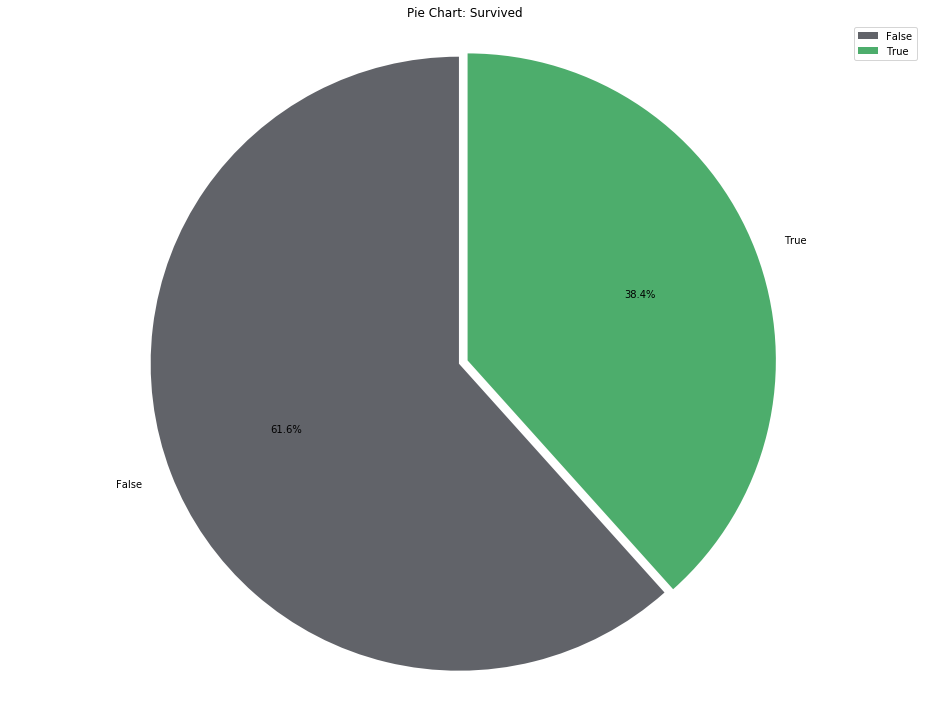

Count plot graph on Survived


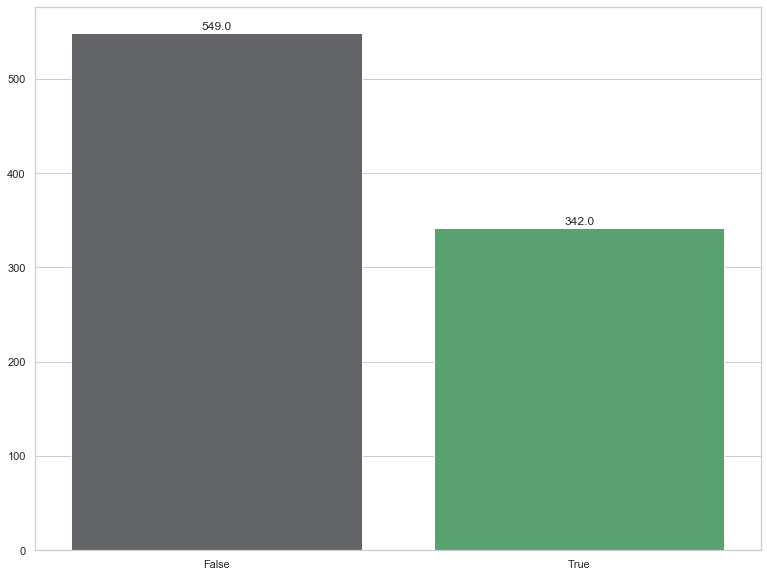

Count plot graph on Survived


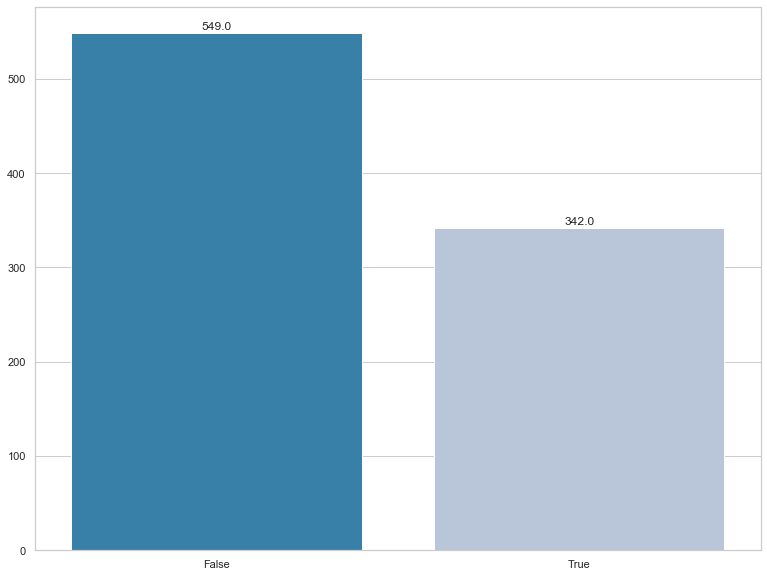

Creating value counts table for feature Survived.


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%








Colors: {1: '#d4af37', 2: '#c0c0c0', 3: '#cd7f32', '1st Class': '#d4af37', '2nd Class': '#c0c0c0', '3rd Class': '#cd7f32'}
Pie graph on Pclass


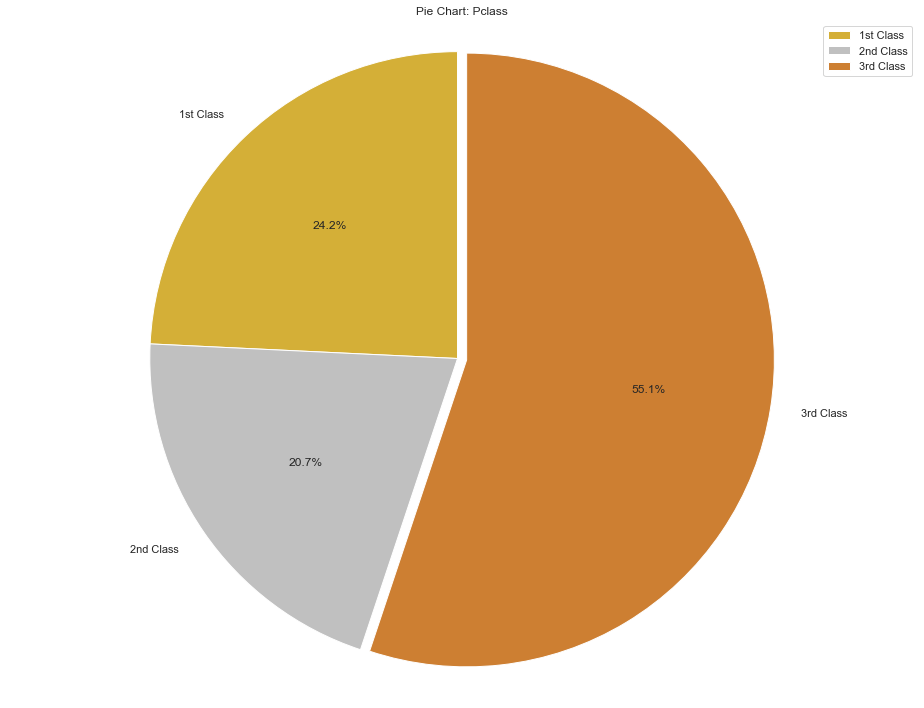

Count plot graph on Pclass


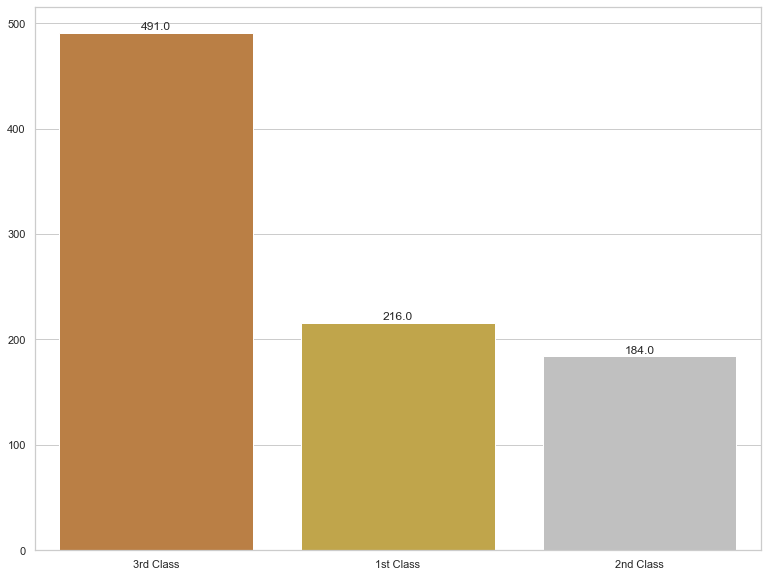

Count plot graph on Pclass


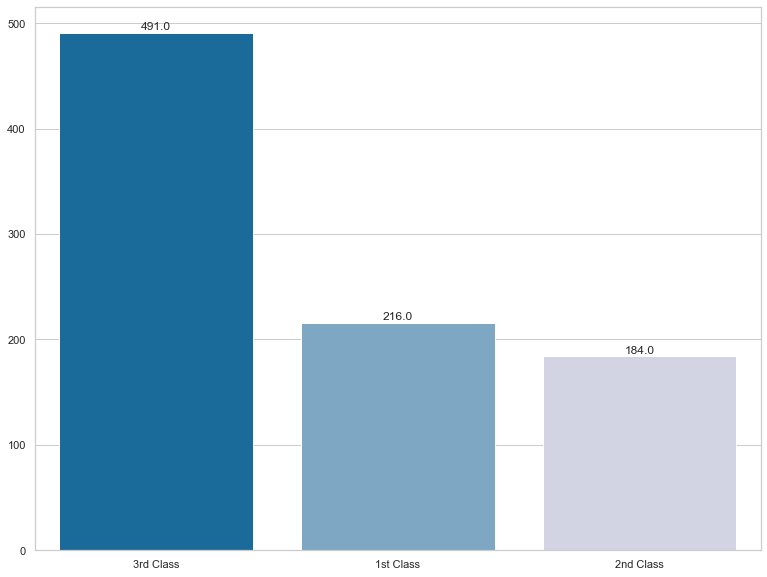

Creating value counts table for feature Pclass.


,Counts,Percantage
Unique Values,,
3rd Class,491,55.1066%
1st Class,216,24.2424%
2nd Class,184,20.6510%


Generating graph violin graph on Pclass by Survived


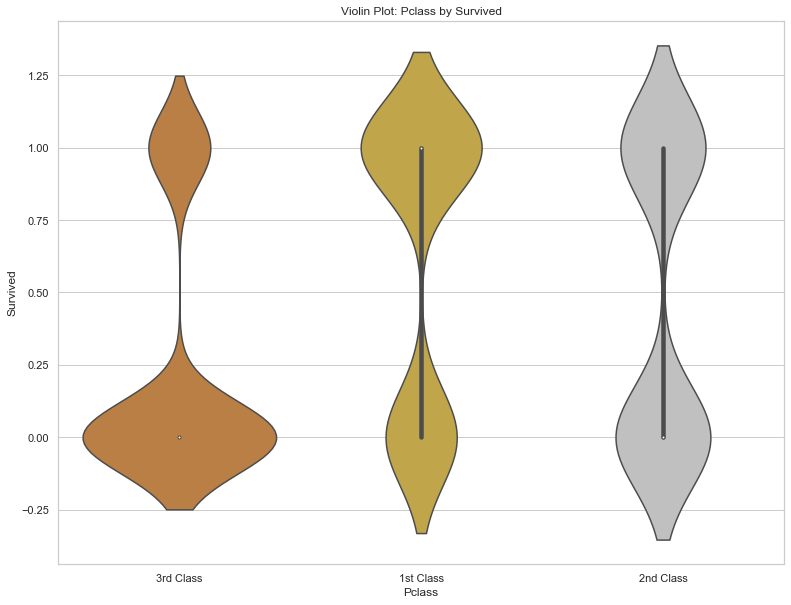







Colors: {'male': '#7eaed3', 'female': '#ffb6c1', 0: '#ffb6c1', 1: '#7eaed3'}
Pie graph on Sex


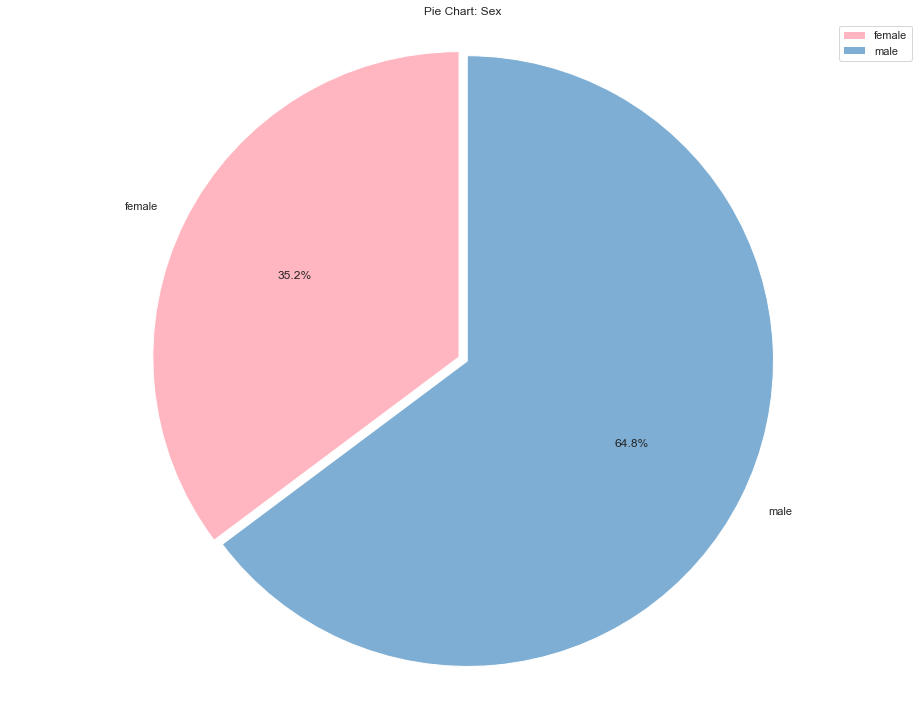

Count plot graph on Sex


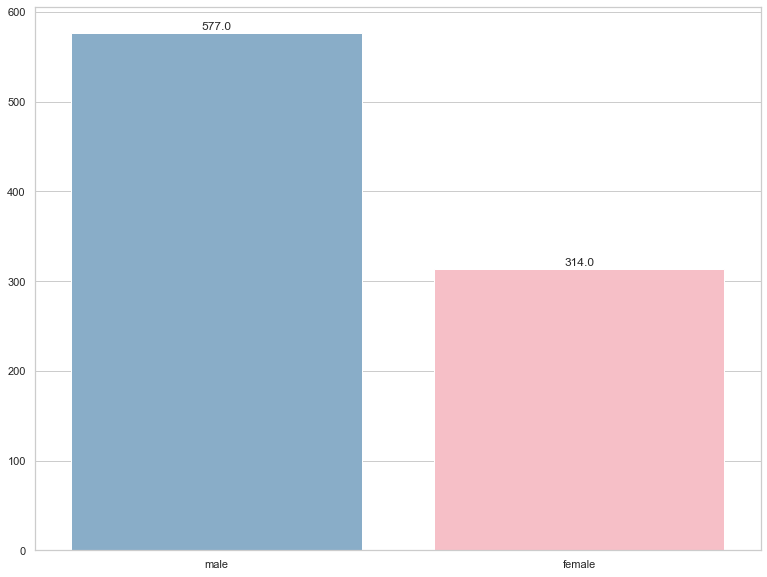

Count plot graph on Sex


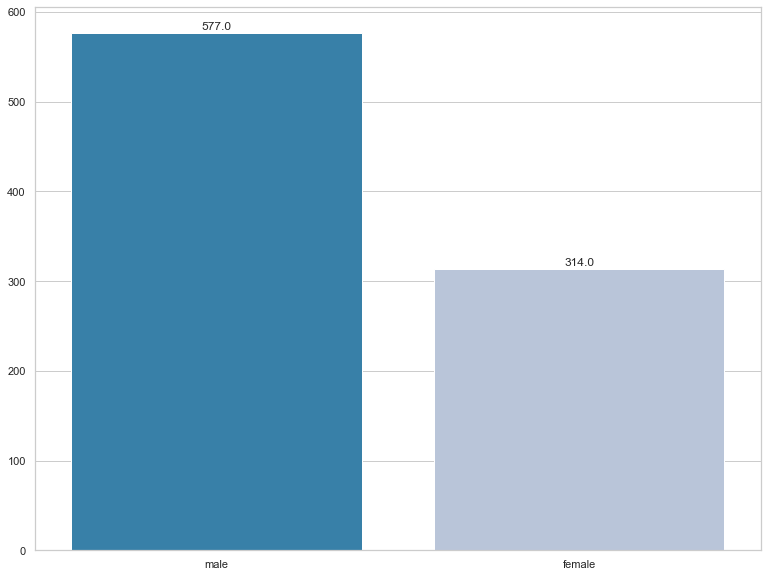

Creating value counts table for feature Sex.


,Counts,Percantage
Unique Values,,
male,577,64.7587%
female,314,35.2413%


Generating graph violin graph on Sex by Survived


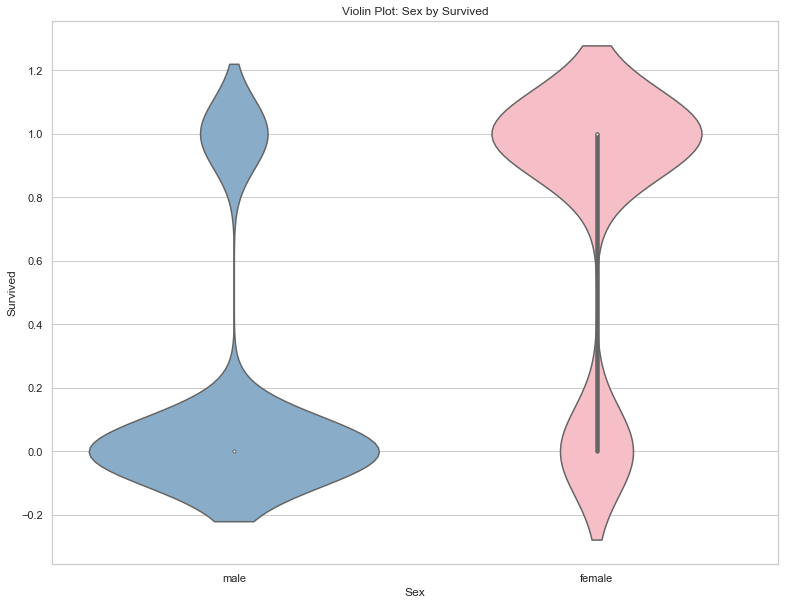







Generating graph for distance plot on Age


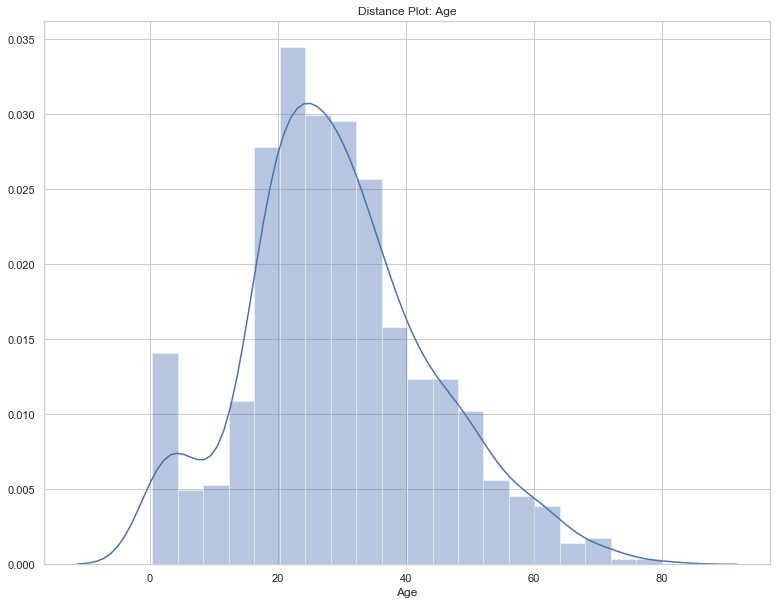

Creating data description table for Age


,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000
var,211.019125








Generating graph for distance plot on SibSp


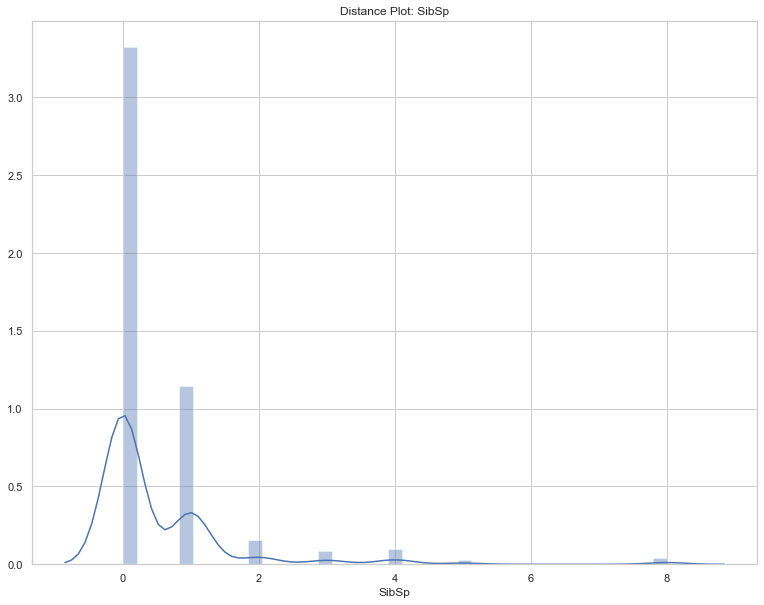

Creating data description table for SibSp


,SibSp
count,891.000000
mean,0.523008
std,1.102743
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,8.000000
var,1.216043








Generating graph for distance plot on Parch


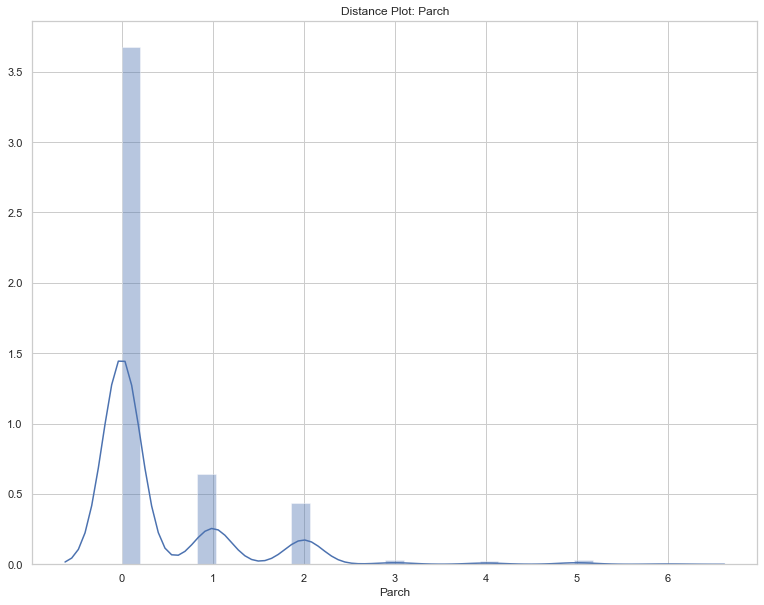

Creating data description table for Parch


,Parch
count,891.000000
mean,0.381594
std,0.806057
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,6.000000
var,0.649728








Generating graph for distance plot on Fare


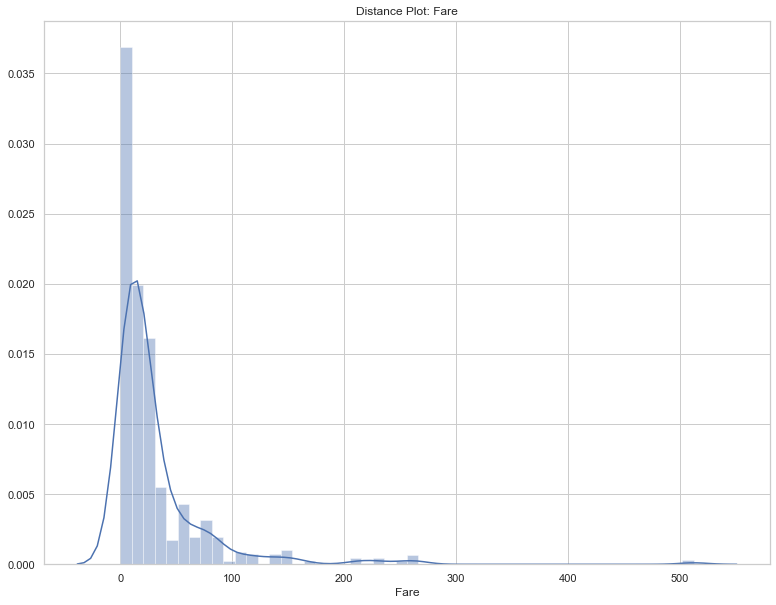

Creating data description table for Fare


,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200
var,2469.436846








Count plot graph on Cabin


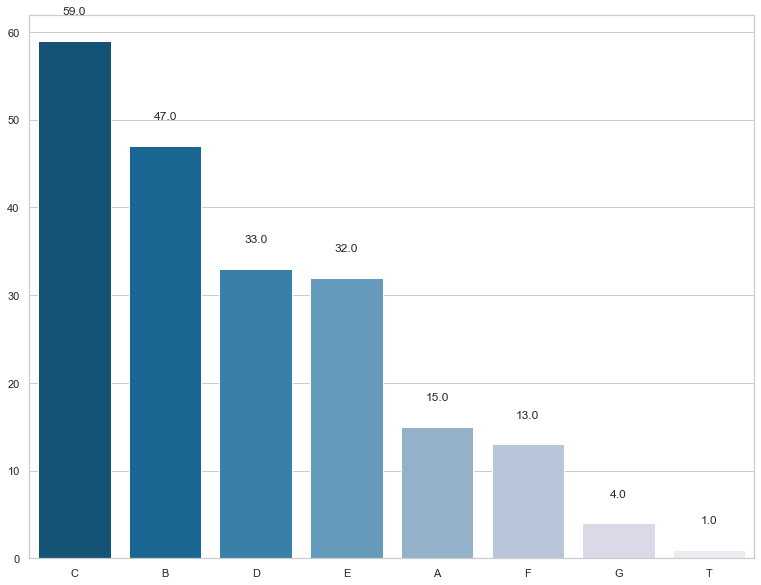

Creating value counts table for feature Cabin.


,Counts,Percantage
Unique Values,,
C,59,28.9216%
B,47,23.0392%
D,33,16.1765%
E,32,15.6863%
A,15,7.3529%
F,13,6.3725%
G,4,1.9608%
T,1,0.4902%


Generating graph violin graph on Cabin by Survived


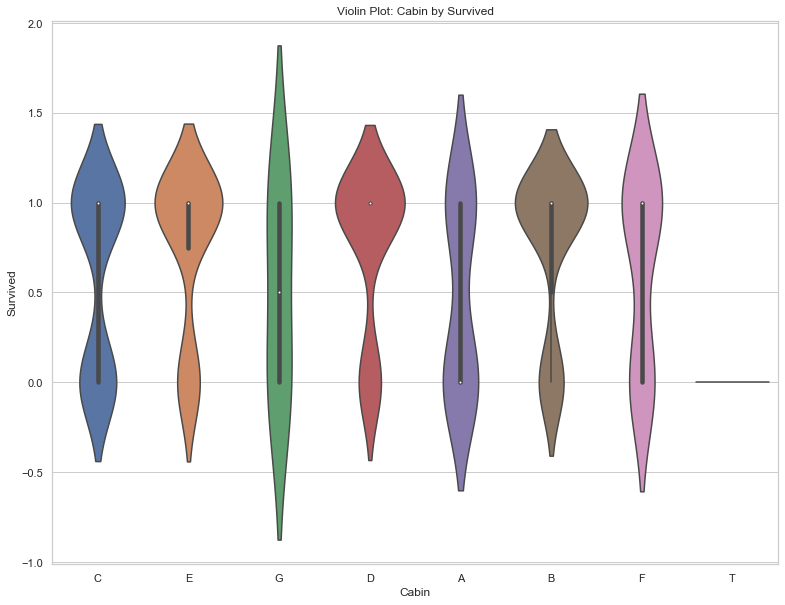







Pie graph on Embarked


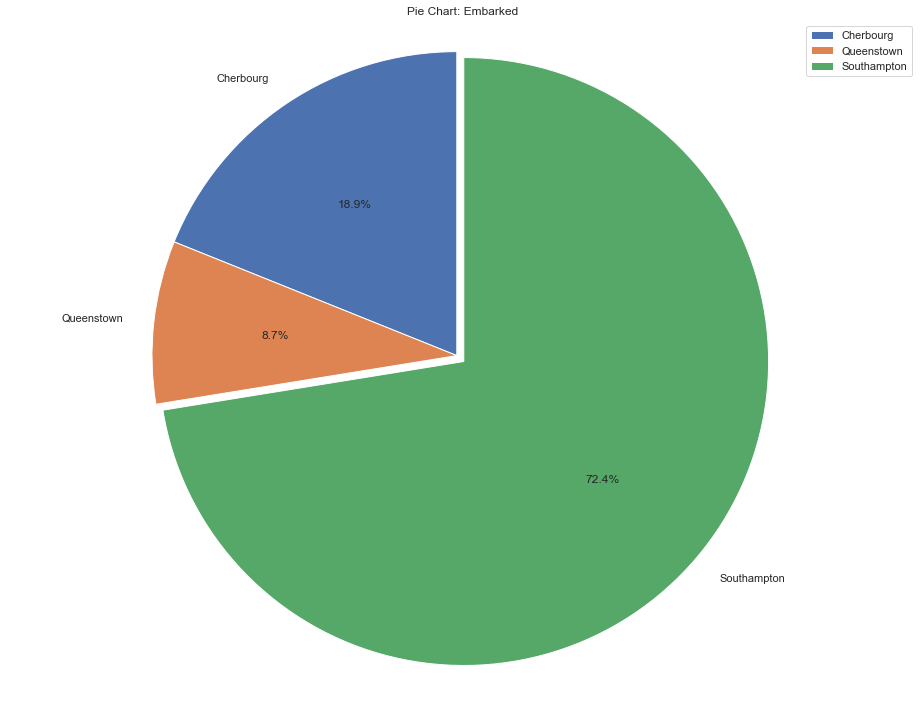

Count plot graph on Embarked


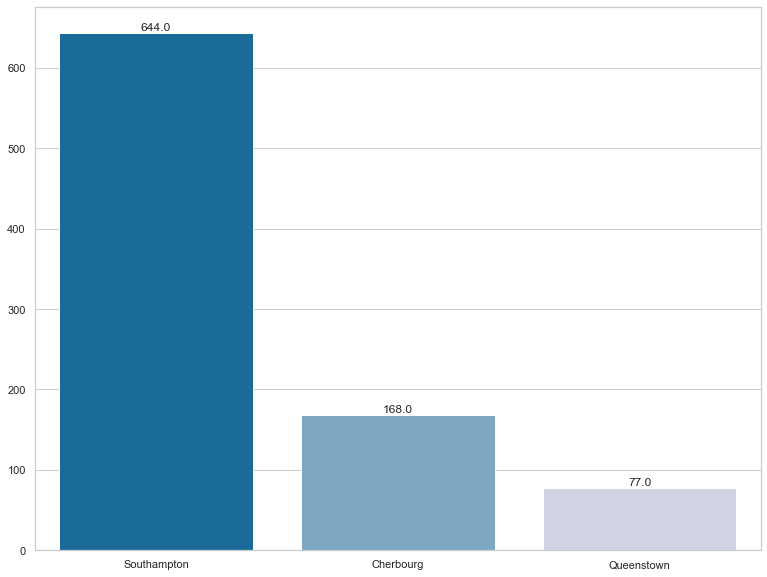

Creating value counts table for feature Embarked.


,Counts,Percantage
Unique Values,,
Southampton,644,72.4409%
Cherbourg,168,18.8976%
Queenstown,77,8.6614%


Generating graph violin graph on Embarked by Survived


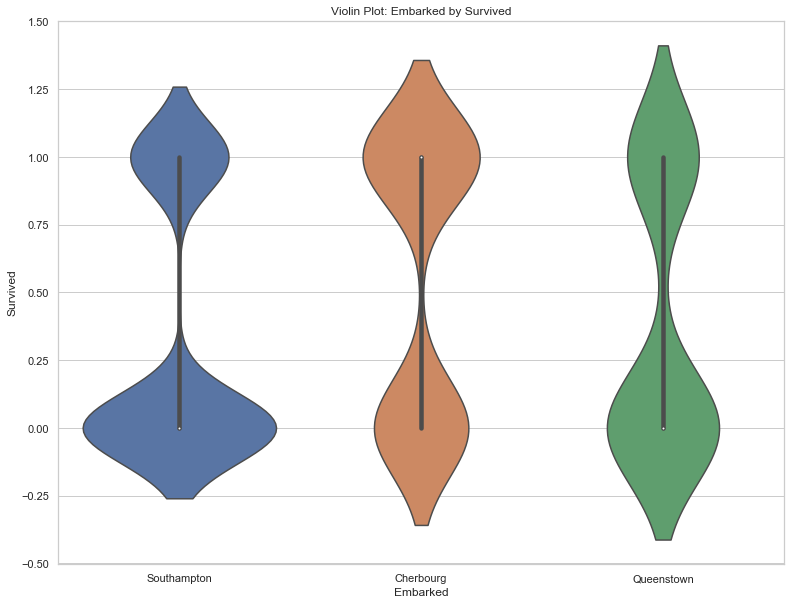

In [38]:
feature_analysis = FeatureAnalysis(df_features,
                                   project_sub_dir=peek_project_dir)
feature_analysis.perform_analysis(df,
                                  dataset_name=dataset_name)
del feature_analysis

# Null Analysis of data

Creating data types table...
Your selected dataframe has 9 features.


,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
SibSp,int64
Parch,int64
Pclass,object
Sex,object
Cabin,object
Embarked,object





Creating missing values table...
Your selected dataframe has 9 columns.
That has 3 columns missing data.



,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2





Generating graph for null bar graph...


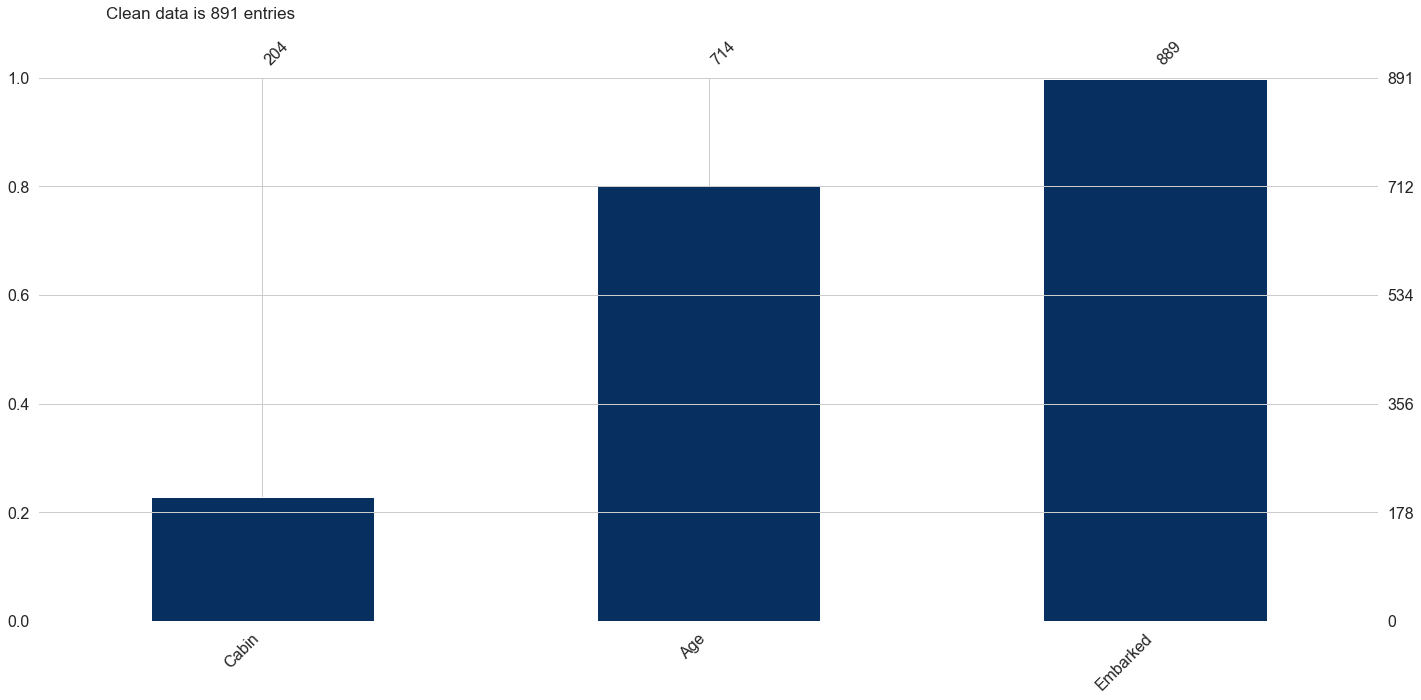




Generating graph for null matrix graph...


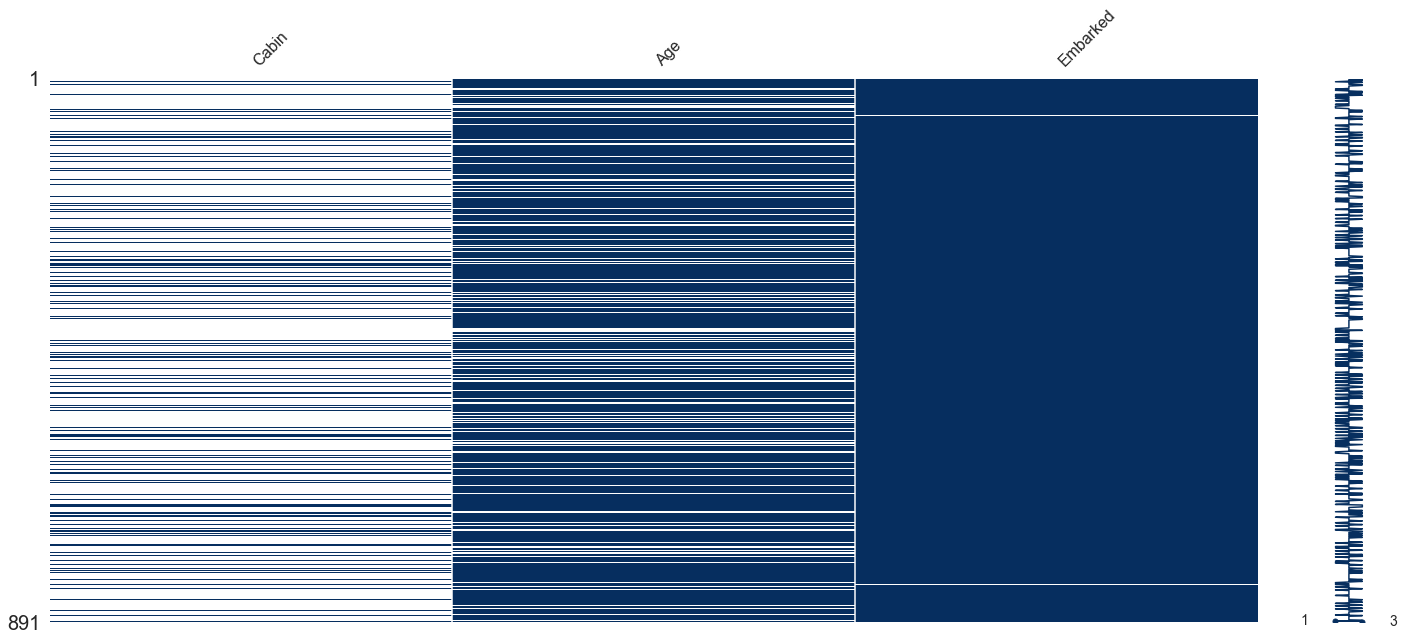




Generating graph for null heatmap...


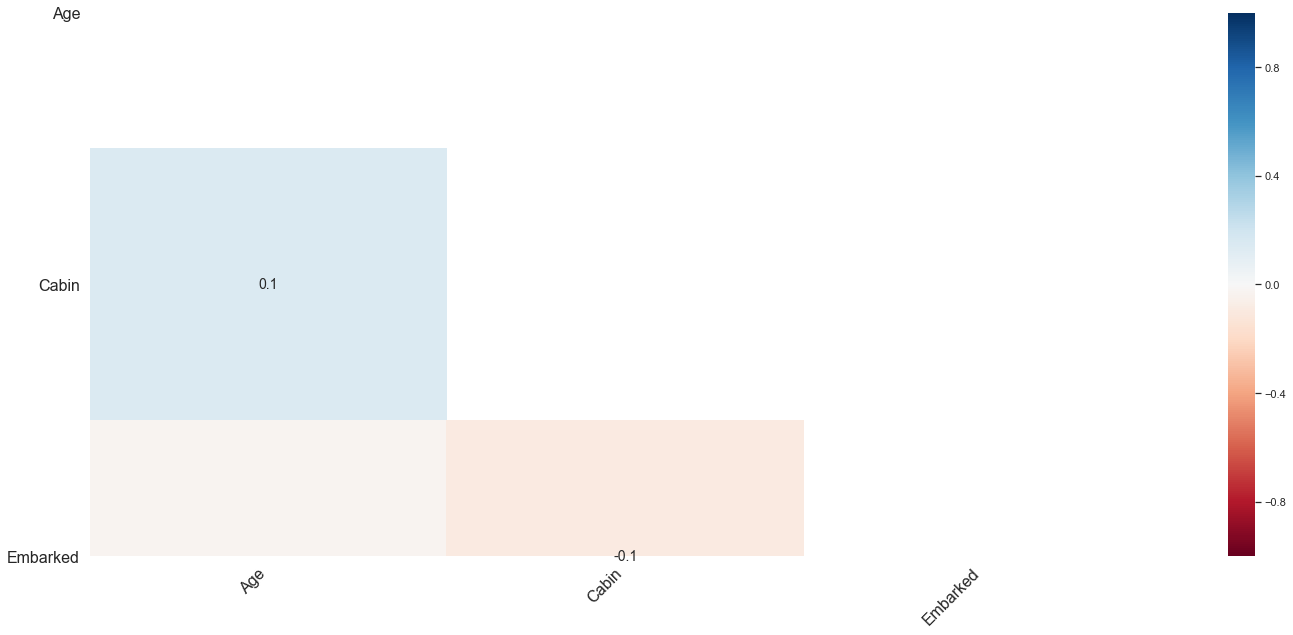




Generating graph for null dendrogram graph...


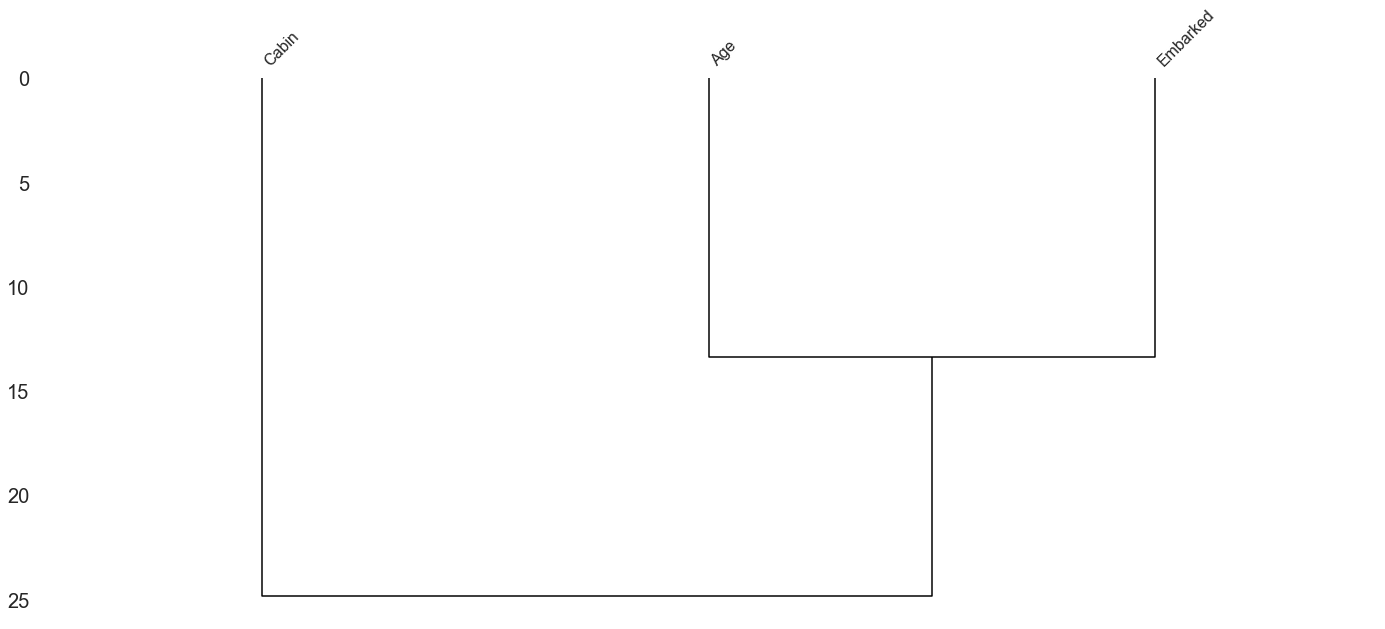

In [39]:
null_analysis = NullAnalysis(df_features,
                             project_sub_dir=peek_project_dir,
                             notebook_mode=notebook_mode)

null_analysis.perform_analysis(df,
                               dataset_name=dataset_name,
                               null_features_only=True)

del null_analysis

## Create a json file of df_features

In [40]:
created_dir = create_dir_structure(os.getcwd(),
                                   f"/eflow Data/{dataset_name}")

In [41]:
df_features.create_json_file_representation(created_dir,
                                            "df_features.json")

In [42]:
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [43]:
df_features.display_features()

String Features: {'Embarked', 'Sex', 'Cabin'}

Categorical Features: {'Pclass'}

------------------------------------------------------------------------------------------
Bool Features: {'Survived'}

------------------------------------------------------------------------------------------
Numerical Features: {'SibSp', 'Age', 'Fare', 'Parch'}

Integer Features: {'SibSp', 'Parch'}

Float Features: {'Age', 'Fare'}

------------------------------------------------------------------------------------------
Target Feature: Survived



In [44]:
remove_unconnected_pipeline_segments()

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def ridge_plot(df,
               feature_name,
               target_feature):

    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.20, light=.7)
    g = sns.FacetGrid(df,
                      row=target_feature,
                      hue=target_feature,
                      aspect=15,
                      height=.4,
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot,
          feature_name,
          clip_on=False,
          shade=True,
          alpha=1,
          lw=1.5,
          bw=.2)
    g.map(sns.kdeplot,
          feature_name,
          clip_on=False,
          color="w",
          lw=2,
          bw=.2)

    g.map(plt.axhline,
          y=0,
          lw=2,
          clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0,
                .2,
                label,
                fontweight="bold",
                color=color,
                ha="left",
                va="center",
                transform=ax.transAxes)


    g.map(label, feature_name)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_size_inches(10, 10, forward=True)
    g.fig.suptitle(f'{target_feature} by {feature_name}')

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


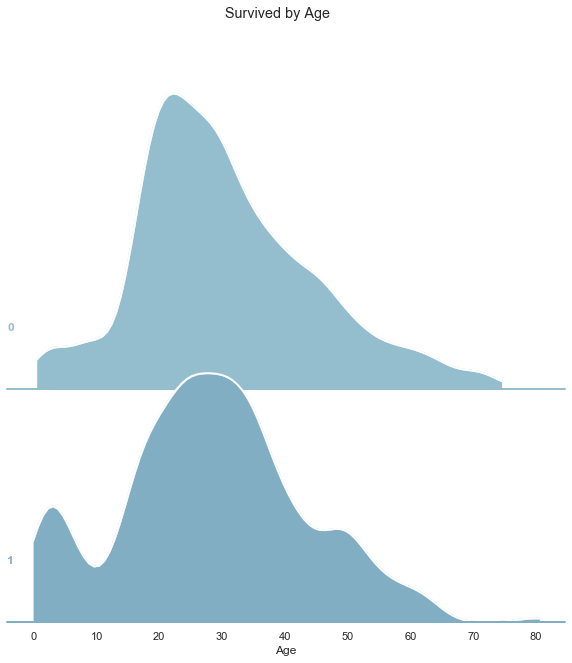

In [46]:
ridge_plot(df,
           "Age",
           target_feature)

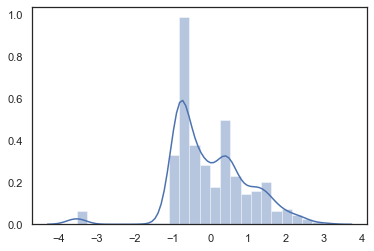

In [47]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, normalize, RobustScaler,QuantileTransformer

test_feature = "Fare"
pt = PowerTransformer()

# Scale data 
new_series = pt.fit_transform(df[[test_feature]]).flatten()

sns.distplot(new_series[~np.isnan(new_series)])

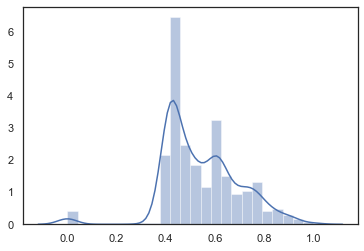

In [48]:
# new_series = df[test_feature]
min_val = min(new_series)
max_val = max(new_series)
tmp_list = []
for val in new_series:
    tmp_list.append((val-min_val)/(max_val - min_val))

new_series = np.array([tmp_list])
sns.distplot(new_series[~np.isnan(new_series)])

In [49]:
from eflow.utils.pandas_utils import descr_table

descr_table(df,
            test_feature,
            to_numeric=True)

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200
var,2469.436846


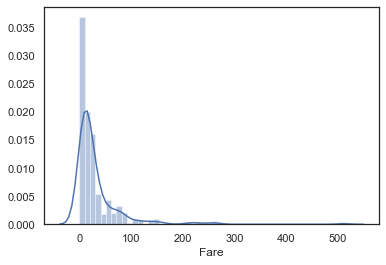

In [50]:
sns.distplot(df[test_feature].dropna())

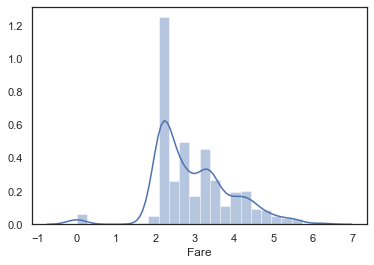

In [51]:
new_series = df[test_feature].dropna()
new_series = np.log(new_series + np.abs(min(new_series)) + 1)
sns.distplot(new_series)

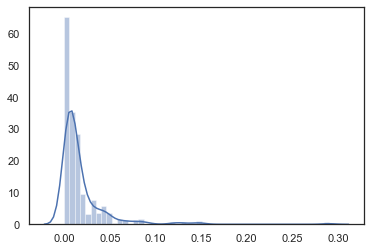

In [52]:
sns.distplot(normalize([df[test_feature].dropna()]).flatten())

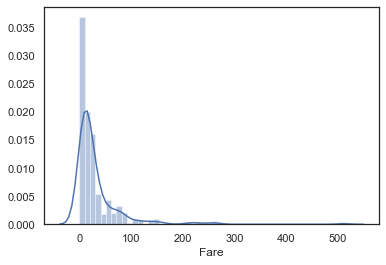

In [53]:
sns.distplot(df[test_feature])

<Figure size 864x576 with 0 Axes>

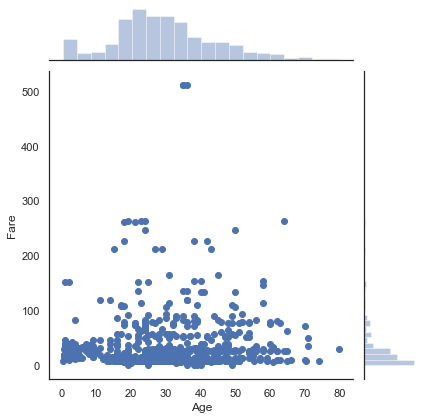

In [61]:
plt.figure(figsize=(12, 8))
sns.jointplot(df["Age"],df["Fare"])
plt.show()
plt.close()

<Figure size 864x576 with 0 Axes>

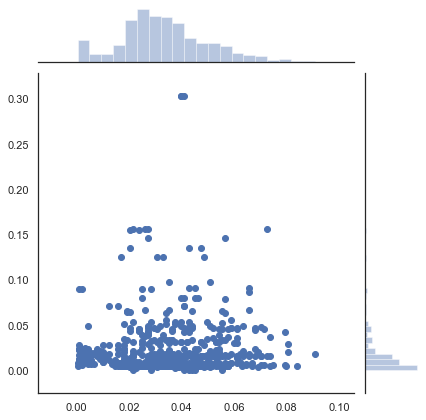

In [60]:
tmp_df = df[["Age", "Fare"]]
tmp_df = tmp_df.dropna()
plt.figure(figsize=(12, 8))
sns.jointplot(normalize([tmp_df["Age"]]).flatten(),
              normalize([tmp_df["Fare"]]).flatten())
plt.show()
plt.close()